# Korpus normalisieren / ausbalancieren

In [1]:
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import ticker
import glob
import math
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# großes DF einlesen 

df_bigger = pd.read_csv('Korpus/corpus_periods.csv', sep=',', encoding='utf-8')

In [3]:
df_bigger.shape

(431959, 11)

In [4]:
# Duplikate löschen

df_bigger = df_bigger.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [5]:
df_bigger.shape

(425188, 11)

## Kandidaten im Korpus ohne Duplikate

In [6]:
df_copy = df_bigger.copy()

In [7]:
df_copy.text = df_copy.text.fillna('')
df_copy.lemmatized_text = df_copy.lemmatized_text.fillna('')
df_copy.cleaned_text = df_copy.cleaned_text.fillna('')

In [8]:
# Teilframes pro Zeitraum erstellen

period_frames = []
periods = list(df_copy['period'].unique())
df_copy_periods = dict(tuple(df_copy.groupby(by='period')))

for df_copy, period in zip(df_copy_periods, periods):
    df_copy_period = df_copy_periods[period]
    period_frames.append(df_copy_period)

In [9]:
# Funktion, die bestimmte Wörter zählt

def count_keywords(df_copy, keywords):
    keyword_dict = {w:w.replace(' ', '_') for w in keywords}

    corpus = ' '.join(df_copy.lemmatized_text).lower()                     
    for w,w2 in keyword_dict.items():
        corpus = corpus.replace(w,w2)

    all_counts = Counter(corpus.split())
    final_counts = {w:all_counts[w2] for w,w2 in keyword_dict.items()}
    return final_counts

In [10]:
# mögliche Kandidaten

keywords = ['atrocemente', 'formidabilmente', 'mostruosamente', 'orrendamente', 
            'orribilmente', 'spaventosamente', 'terribilmente', 'tremendamente', 
            'molto', 'angoscia', 'angosciare', 'ansia', 'atterrire', 'panico', 
            'paura', 'raccapricciare', 'raccapriccio', 'schifo', 'sgomentare', 
            'sgomento', 'spaventare', 'spavento', 'terrore', 'domani', 'finora', 
            'ieri', 'oggi', 'presto', 'raramente', 'sempre', 'spesso']

In [11]:
candidates = {}

for df_copy, period in zip(period_frames, periods):
    res = count_keywords(df_copy, keywords)
    candidates[period] = res

In [12]:
table = pd.DataFrame.from_dict(candidates, orient='index')
table

,atrocemente,formidabilmente,mostruosamente,orrendamente,orribilmente,spaventosamente,terribilmente,tremendamente,molto,angoscia,...,spavento,terrore,domani,finora,ieri,oggi,presto,raramente,sempre,spesso
1700-1750,1,0,1,1,17,5,7,0,10543,16,...,217,135,32,200,25,600,274,9,1962,522
1751-1800,3,0,0,1,24,1,9,0,15469,69,...,96,147,180,243,106,618,574,47,3064,822
1801-1850,17,0,2,15,51,4,33,2,21552,226,...,344,451,418,247,476,2092,1046,44,5764,1308
1851-1900,87,12,22,40,249,47,145,67,46277,699,...,780,907,1912,631,1034,3295,2604,216,12449,2453
1901-1950,72,18,36,41,192,134,249,50,26760,699,...,477,752,1741,488,1190,2686,1505,302,7431,1680
1951-2000,130,8,112,132,145,146,238,142,31274,692,...,336,710,1768,1512,5049,5709,1756,836,7635,2748
2001-2021,196,193,205,202,201,201,216,212,28674,266,...,221,361,1785,714,3311,5865,989,250,7110,1603


In [13]:
table.to_csv('Korpus/candidates_without_duplicates.csv', sep=';')

## Adverbien in einzelnen Texten zählen

In [14]:
def countMos(str):
    wordslist = list(str.split())
    return wordslist.count('mostruosamente')

def countOrr(str):
    wordslist = list(str.split())
    return wordslist.count('orribilmente')

def countSpa(str):
    wordslist = list(str.split())
    return wordslist.count('spaventosamente')

def countTerr(str):
    wordslist = list(str.split())
    return wordslist.count('terribilmente')

def countTre(str):
    wordslist = list(str.split())
    return wordslist.count('tremendamente')

In [15]:
df_bigger['mostruosamente'] = df_bigger['cleaned_text'].astype(str).apply(countMos)
df_bigger['orribilmente'] = df_bigger['cleaned_text'].astype(str).apply(countOrr)
df_bigger['spaventosamente'] = df_bigger['cleaned_text'].astype(str).apply(countSpa)
df_bigger['terribilmente'] = df_bigger['cleaned_text'].astype(str).apply(countTerr)
df_bigger['tremendamente'] = df_bigger['cleaned_text'].astype(str).apply(countTre)

In [16]:
df_bigger[df_bigger['terribilmente'] >= 1].head()

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text,mostruosamente,orribilmente,spaventosamente,terribilmente,tremendamente
23,BibItDiversi3.txt,BibIt,diversi,Rime degli Arcadi / tomo quinto,1717.0,1700-1750,poesia,74909.0,"Acasto Lampeatico\n1\nAhimè, che il carro mio ...","acasto lampeatico ahimè, che il carro mio fr...","acasto lampeatico \n 1 \n ahimè , che il carro...",0,2,0,1,0
6020,GBterribilmente.csv,Gutenberg,Lodovico Antonio Muratori,"Annali d''Italia, vol. 1: dal principio dell''...",1749.0,1700-1750,prosa letteraria,36.0,[3124]. Nelle altre medaglie e nelle iscrizion...,. nelle altre medaglie e nelle iscrizion...,[ 3124 ] . nella altro medaglia e nella iscriz...,0,0,0,1,0
6021,GBterribilmente.csv,Gutenberg,Lodovico Antonio Muratori,"Annali d''Italia, vol. 1: dal principio dell''...",1749.0,1700-1750,prosa letteraria,42.0,", dov''egli passava, lasciava la micidial infe...",", dov egli passava, lasciava la micidial infe...",", dov''egli passare , lasciare il micidial inf...",0,0,0,1,0
6022,GBterribilmente.csv,Gutenberg,Lodovico Antonio Muratori,"Annali d''Italia, vol. 4: dal principio dell''...",1749.0,1700-1750,prosa letteraria,45.0,"in una casa privata, e la seguente mane imbarc...","in una casa privata, e la seguente mane imbarc...","in uno casa privato , e il seguente mane imbar...",0,0,0,1,0
6030,GBterribilmente.csv,Gutenberg,Lodovico Antonio Muratori,"Annali d''Italia, vol. 7: dal principio dell''...",1749.0,1700-1750,prosa letteraria,35.0,"a dar gli ordini opportuni, trovandosi coraggi...","a dar gli ordini opportuni, trovandosi coraggi...","a dare il ordine opportuno , trovare coraggios...",0,0,0,1,0


## Gewichtung der Texte, die die Kandidaten und die Quelldomäne enthalten

In [17]:
adverbs = ['mostruosamente', 'orribilmente', 'spaventosamente', 'terribilmente', 'tremendamente']

domaine = ['angoscia', 'angosciare', 'ansia', 'atterrire', 'panico', 'paura', 'raccapricciare', 
           'raccapriccio', 'schifo', 'sgomentare', 'sgomento', 'spaventare', 'spavento', 'terrore']

In [18]:
def is_word(cleaned_text):
    if any(word in cleaned_text for word in adverbs):  
        x = 1          # größte Gewichtung bei den Adverbien       
    elif any(word in cleaned_text for word in domaine):       
        x = 0.8        # ein bisschen Gewichtung bei der Quelldomäne                                         
    else:
        x = 0.5        # kleine Gewichtung beim Rest
    return x

In [19]:
df_bigger['weight'] = df_bigger['cleaned_text'].astype(str).apply(is_word)  

In [20]:
df_bigger[df_bigger['weight'] == 1].head()

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text,mostruosamente,orribilmente,spaventosamente,terribilmente,tremendamente,weight
17,ita000099.txt,ItaDraCor,Annibale Marchese,Il Crispo,1715.0,1700-1750,teatro,16961.0,"Degno mio germe, per cui sol vedrassi\nA l'org...","degno mio germe, per cui sol vedrassi a l orgo...","degno mio germe , per cui sole vedrassi \n a i...",0,2,0,0,0,1.0
20,BibItDiversi4.txt,BibIt,diversi,Rime degli Arcadi / tomo secondo,1716.0,1700-1750,poesia,76203.0,"Aci Delpusiano\n1\nDov'è quella famosa, alta, ...","aci delpusiano dov è quella famosa, alta, su...",Aci delpusiano \n 1 \n dove essere quella famo...,0,1,0,0,0,1.0
21,BibItDiversi6.txt,BibIt,diversi,Rime degli Arcadi / tomo terzo,1716.0,1700-1750,poesia,79958.0,Adelindo Gerenio\n1\nVissi lunga stagione al M...,adelindo gerenio vissi lunga stagione al mon...,adelindo gerenio \n 1 \n vissi lungo stagione ...,0,2,0,0,0,1.0
22,BibItDiversi2.txt,BibIt,diversi,Rime degli Arcadi / tomo quarto,1717.0,1700-1750,poesia,74529.0,"Adalsio Metoneo\n1\nQuesti, più assai che del ...","adalsio metoneo questi, più assai che del mi...","adalsio metoneo \n 1 \n questi , molto assai c...",0,2,0,0,0,1.0
23,BibItDiversi3.txt,BibIt,diversi,Rime degli Arcadi / tomo quinto,1717.0,1700-1750,poesia,74909.0,"Acasto Lampeatico\n1\nAhimè, che il carro mio ...","acasto lampeatico ahimè, che il carro mio fr...","acasto lampeatico \n 1 \n ahimè , che il carro...",0,2,0,1,0,1.0


## Normalisierung

In [21]:
# Einzeldataframes für die Zeiträume

df1 = df_bigger[df_bigger['period']=='1700-1750']
df2 = df_bigger[df_bigger['period']=='1751-1800']
df3 = df_bigger[df_bigger['period']=='1801-1850']
df4 = df_bigger[df_bigger['period']=='1851-1900']
df5 = df_bigger[df_bigger['period']=='1901-1950']
df6 = df_bigger[df_bigger['period']=='1951-2000']
df7 = df_bigger[df_bigger['period']=='2001-2021']

### Texte mit Adverbien beiseitelegen

damit sie drin bleiben, gleich viele sind etc. (vgl. Kandidatenliste 'Korpus/candidates_without_duplicates.csv')

#### 1700-1750

In [22]:
ad1 = df1[df1['weight']==1]

ad1_mostruosamente = ad1[ad1['mostruosamente']>=1]
ad1_orribilmente = ad1[ad1['orribilmente']>=1]
ad1_spaventosamente = ad1[ad1['spaventosamente']>=1]
ad1_terribilmente = ad1[ad1['terribilmente']>=1]

In [23]:
# Zusammenfügen der Adverbetxte in diesem Zeitraum 
ad1_new = pd.concat([ad1_mostruosamente, ad1_orribilmente, ad1_spaventosamente, ad1_terribilmente])

In [24]:
ad1_new.shape

(24, 17)

In [25]:
ad1_new = ad1_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [26]:
ad1_new.shape

(23, 17)

#### 1751-1800

In [27]:
ad2 = df2[df2['weight']==1]

ad2_orribilmente = ad2[ad2['orribilmente']>=1]
ad2_spaventosamente = ad2[ad2['spaventosamente']>=1]
ad2_terribilmente = ad2[ad2['terribilmente']>=1]

In [28]:
ad2_new = pd.concat([ad2_orribilmente, ad2_spaventosamente, ad2_terribilmente])

In [29]:
ad2_new.shape

(21, 17)

In [30]:
ad2_new = ad2_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [31]:
ad2_new.shape

(20, 17)

#### 1801-1850

In [32]:
ad3 = df3[df3['weight']==1]

ad3_mostruosamente = ad3[ad3['mostruosamente']>=1]
ad3_orribilmente = ad3[ad3['orribilmente']>=1]
ad3_spaventosamente = ad3[ad3['spaventosamente']>=1]
ad3_terribilmente = ad3[ad3['terribilmente']>=1]
ad3_tremendamente = ad3[ad3['tremendamente']>=1]

In [33]:
ad3_new = pd.concat([ad3_mostruosamente, ad3_orribilmente, ad3_spaventosamente, ad3_terribilmente, ad3_tremendamente])

In [34]:
ad3_new.shape

(73, 17)

In [35]:
ad3_new = ad3_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [36]:
ad3_new.shape

(68, 17)

#### 1851-1900

In [37]:
ad4 = df4[df4['weight']==1]

In [38]:
# dieser Abschnitt ist zu lang (hat zu lange Text)
# vorher die längsten Texte entfernen

ad4[ad4['words']>200000]

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text,mostruosamente,orribilmente,spaventosamente,terribilmente,tremendamente,weight
14962,LLAzeglio2.txt,Liber Liber,Massimo d'Azeglio,Racconti / leggende e ricordi della vita italiana,1856.0,1851-1900,personale,276056.0,"Massimo d'Azeglio\n\n\nRacconti, leggende e ri...","massimo d azeglio racconti, leggende e ricor...","Massimo di Azeglio \n\n\n racconto , leggenda ...",0,0,0,3,0,1.0
15640,li0202.txt,CLiGS Ro,Giuseppe Rovani,Cent'anni,1859.0,1851-1900,prosa letteraria,417944.0,"Convien risalire a quindici anni addietro, all...","convien risalire a quindici anni addietro, all...","convien risalire a quindici anno addietro , al...",0,2,0,7,1,1.0
15686,li0566.txt,CLiGS Ro,Francesco Domenico Guerrazzi,Pasquale Paoli/ ossia La rotta di Ponte Nuovo,1860.0,1851-1900,prosa letteraria,202276.0,"Gli dei di Ausonia se ne andarono, ed il suo c...","gli dei di ausonia se ne andarono, ed il suo c...","il del di ausonia se ne andare , ed il suo cie...",0,2,0,1,1,1.0
16705,li1152.txt,CLiGS Ro,Ippolito Nievo,Le confessioni d'un italiano,1867.0,1851-1900,prosa letteraria,337437.0,"Io nacqui veneziano ai 18 ottobre del 1775, gi...","io nacqui veneziano ai ottobre del , gi...","io nascere veneziano al 18 ottobre del 1775 , ...",1,0,2,1,0,1.0
16707,LLBersezio2.txt,Liber Liber,Vittorio Bersezio,La plebe,1867.0,1851-1900,prosa letteraria,716250.0,﻿Vittorio Bersezio\nLa plebe\n\nPARTE PRIMA\n\...,vittorio bersezio la plebe parte prima pre...,﻿vittorio bersezio \n il plebe \n\n parte prim...,2,3,2,1,9,1.0
25665,BibItSanctis1.txt,BibIt,Francesco de Sanctis,Storia della letteratura italiana,1879.0,1851-1900,espositivo,294116.0,I.\nI Siciliani\n⟨1. Il contrasto di Cielo d'A...,i. i siciliani . il contrasto di cielo d alc...,i. \n il siciliano \n ⟨1 . il contrasto di cie...,0,0,0,2,0,1.0
34438,li0644.txt,CLiGS Ro,Federico de Roberto,I Viceré,1894.0,1851-1900,prosa letteraria,209073.0,"Giuseppe, dinanzi al portone, trastullava il s...","giuseppe, dinanzi al portone, trastullava il s...","Giuseppe , dinanzi al portone , trastullare il...",0,0,2,1,0,1.0


In [39]:
ad4_smaller = ad4[ad4['words']<200000]

In [40]:
# immer noch zu lang 

ad4_smaller[ad4_smaller['words']>148000]

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text,mostruosamente,orribilmente,spaventosamente,terribilmente,tremendamente,weight
14959,LLAmari2.txt,Liber Liber,Michele Amari,Storia dei musulmani di Sicilia I,1854.0,1851-1900,espositivo,188057.0,Michele Amari\nStoria dei musulmani di Sicilia...,michele amari storia dei musulmani di sicilia ...,Michele amari \n storia del musulmani di Sicil...,0,2,0,0,0,1.0
15071,LLAmari3.txt,Liber Liber,Michele Amari,Storia dei musulmani di Sicilia II,1858.0,1851-1900,espositivo,185358.0,Michele Amari\nStoria dei musulmani di Sicilia...,michele amari storia dei musulmani di sicilia ...,Michele amari \n storia del musulmani di Sicil...,0,2,0,0,0,1.0
16706,li1445.txt,CLiGS Ro,Ferdinando Petruccelli della Gattina,Memorie di Giuda,1867.0,1851-1900,prosa letteraria,148219.0,"Era il 15 del mese di Thisri, la sera della fe...","era il del mese di thisri, la sera della fe...","essere il 15 del mese di thisri , il sera dell...",0,4,0,3,0,1.0


In [41]:
ad4_smallest = ad4_smaller[ad4_smaller['words']<148000]

In [45]:
ad4_mostruosamente = ad4_smallest[ad4_smallest['mostruosamente']>=1]
ad4_orribilmente1 = ad4_smallest[ad4_smallest['orribilmente']>1]     
ad4_orribilmente2 = ad4_smallest[ad4_smallest['orribilmente']==1].sample(n=84 , random_state=1)     #63  74
ad4_spaventosamente = ad4_smallest[ad4_smallest['spaventosamente']>=1]
ad4_terribilmente = ad4_smallest[ad4_smallest['terribilmente']>=1]
ad4_tremendamente1 = ad4_smallest[ad4_smallest['tremendamente']>1] 
ad4_tremendamente2 = ad4_smallest[ad4_smallest['tremendamente']==1].sample(n=45 , random_state=1)   #33 44

In [46]:
ad4_new = pd.concat([ad4_mostruosamente, ad4_orribilmente1, ad4_orribilmente2, ad4_spaventosamente,
                     ad4_terribilmente, ad4_tremendamente1, ad4_tremendamente2])

In [47]:
ad4_new.shape

(296, 17)

In [48]:
ad4_new = ad4_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [49]:
ad4_new.shape

(281, 17)

#### 1901-1950

In [50]:
ad5 = df5[df5['weight']==1]

In [51]:
ad5_mostruosamente = ad5[ad5['mostruosamente']>=1]
ad5_orribilmente1 = ad5[ad5['orribilmente']>1]     
ad5_orribilmente2 = ad5[ad5['orribilmente']==1].sample(n=115 , random_state=1)
ad5_spaventosamente = ad5[ad5['spaventosamente']>=1]
ad5_terribilmente1 = ad5[ad5['terribilmente']>1]   
ad5_terribilmente2 = ad5[ad5['terribilmente']==1].sample(n=106 , random_state=1)
ad5_tremendamente = ad5[ad5['tremendamente']>=1]

In [52]:
ad5_new = pd.concat([ad5_mostruosamente, ad5_orribilmente1, ad5_orribilmente2, ad5_spaventosamente, 
                     ad5_terribilmente1, ad5_terribilmente2, ad5_tremendamente])

In [53]:
ad5_new.shape

(435, 17)

In [54]:
ad5_new = ad5_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [55]:
ad5_new.shape

(418, 17)

#### 1951-2000

In [56]:
ad6 = df6[df6['weight']==1]

In [57]:
ad6_mostruosamente1 = ad6[ad6['mostruosamente']>1]    
ad6_mostruosamente2 = ad6[ad6['mostruosamente']==1].sample(n=44 , random_state=1)
ad6_orribilmente = ad6[ad6['orribilmente']>=1]        
ad6_spaventosamente1 = ad6[ad6['spaventosamente']>1]  
ad6_spaventosamente2 = ad6[ad6['spaventosamente']==1].sample(n=126 , random_state=1)
ad6_terribilmente1 = ad6[ad6['terribilmente']>1]      
ad6_terribilmente2 = ad6[ad6['terribilmente']==1].sample(n=111 , random_state=1)
ad6_tremendamente1 = ad6[ad6['tremendamente']>1]      
ad6_tremendamente2 = ad6[ad6['tremendamente']==1].sample(n=43 , random_state=1)

In [58]:
ad6_new = pd.concat([ad6_mostruosamente1, ad6_mostruosamente2, ad6_orribilmente, ad6_spaventosamente1, ad6_spaventosamente2,
                     ad6_terribilmente1, ad6_terribilmente2, ad6_tremendamente1, ad6_tremendamente2])

In [59]:
ad6_new.shape

(487, 17)

In [60]:
ad6_new = ad6_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [61]:
ad6_new.shape

(479, 17)

#### 2001-2021

In [62]:
ad7 = df7[df7['weight']==1]

In [63]:
ad7_mostruosamente1 = ad7[ad7['mostruosamente']>1]   
ad7_mostruosamente2 = ad7[ad7['mostruosamente']==1].sample(n=39 , random_state=1)
ad7_orribilmente1 = ad7[ad7['orribilmente']>1]        
ad7_orribilmente2 = ad7[ad7['orribilmente']==1].sample(n=135 , random_state=1)
ad7_spaventosamente1 = ad7[ad7['spaventosamente']>1] 
ad7_spaventosamente2 = ad7[ad7['spaventosamente']==1].sample(n=141 , random_state=1)
ad7_terribilmente1 = ad7[ad7['terribilmente']>1]     
ad7_terribilmente2 = ad7[ad7['terribilmente']==1].sample(n=138 , random_state=1)
ad7_tremendamente1 = ad7[ad7['tremendamente']>1]      
ad7_tremendamente2 = ad7[ad7['tremendamente']==1].sample(n=48 , random_state=1)

In [64]:
ad7_new = pd.concat([ad7_mostruosamente1, ad7_mostruosamente2, ad7_orribilmente1, ad7_orribilmente2, ad7_spaventosamente1, 
                     ad7_spaventosamente2, ad7_terribilmente1, ad7_terribilmente2, ad7_tremendamente1, ad7_tremendamente2])

In [65]:
ad7_new.shape

(515, 17)

In [66]:
ad7_new = ad7_new.drop_duplicates(subset=['author', 'title', 'year', 'text'])

In [67]:
ad7_new.shape

(513, 17)

### Rest normalisieren

In [68]:
# Normalisierung durch zufälliges Ziehen ohne Zurücklegen von Samples (Texten) im Rest (Texte ohne wichtige Adverbien)
# Samplegröße individuell festgegelegt durch Ausprobieren 
# Ziel: ungefähres Übereinstimmen der Tokenanzahl 
# Bevorzugt gewichtete Texte nehmen 

rest1 = df1[df1['weight']!=1]                                                           # 1700-1750
rest2 = df2[df2['weight']!=1].sample(n=1280 , random_state=1, weights='weight')         # 1751-1800
rest3 = df3[df3['weight']!=1].sample(n=650 , random_state=1, weights='weight')          # 1801-1850
rest4 = df4[df4['weight']!=1].sample(n=150 , random_state=1, weights='weight')          # 1851-1900
rest5 = df5[df5['weight']!=1].sample(n=1600 , random_state=3, weights='weight')         # 1901-1950
rest6 = df6[df6['weight']!=1].sample(n=36080 , random_state=3, weights='weight')        # 1951-2000
rest7 = df7[df7['weight']!=1].sample(n=86400 , random_state=1, weights='weight')        # 2001-2021

### Zusammenfügen

In [69]:
# Zusammenfügen der Zeiträume und Samples zu einem neuen Dataframe

df_norm = pd.concat([ad1_new, rest1, ad2_new, rest2, ad3_new, rest3, ad4_new, 
                     rest4, ad5_new, rest5, ad6_new, rest6, ad7_new, rest7])

In [70]:
# chronologisch ordnen

df_norm= df_norm.sort_values(by=['year'])

In [71]:
# Spalten neu anordnen und unnötige entfernen

df_norm = df_norm[['doc', 'source', 'author', 'title', 'year', 'period', 'text_type', 'words', 'text', 'cleaned_text', 'lemmatized_text']]

In [3]:
df_norm.head()

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text
0,Personali.IV.4.Testo.txt,MIDIA,Vincenzo da Filicaia,Lettere inedite a Lorenzo Magalotti,1700.0,1700-1750,personale,10073.0,"IV. 4. Vincenzo da Filicaia, Lettere inedite a...","iv. . vincenzo da filicaia, lettere inedite a...","iv . 4 . Vincenzo da filicaia , lettere inedit..."
1,Personali.IV.15.Testo.txt,MIDIA,Pietro Giannone,Vita scritta da lui medesimo,1700.0,1700-1750,personale,10118.0,[Proemio]\nPrendo a scrivere la mia vita e qua...,proemio prendo a scrivere la mia vita e quan...,[ proemio ] \n prendere a scrivere il mio vita...
2,Espositivi.IV.4.Testo.txt,MIDIA,Ludovico Antonio Muratori,Antichità italiane,1700.0,1700-1750,espositivo,8990.0,"﻿IV. 4. Ludovico Antonio Muratori, Antichità i...","iv. . ludovico antonio muratori, antichità i...","﻿iv . 4 . Ludovico Antonio muratori , antichit..."
3,Personali.IV.5.Testo.txt,MIDIA,Lorenzo Magalotti,Lettere odorose (1693-1705),1700.0,1700-1750,personale,8374.0,"IV. 5. Lorenzo Magalotti, Lettere odorose (169...","iv. . lorenzo magalotti, lettere odorose ...","iv . 5 . Lorenzo magalotti , lettere odoroso (..."
4,Poesia.IV.1.Testo.txt,MIDIA,Giuseppe Paolucci (Alessi Cillenio),Poesie,1700.0,1700-1750,poesia,10862.0,IV. 1. Rime degli Arcadi: Alessi Cillenio (Giu...,iv. . rime degli arcadi: alessi cillenio giu...,iv . 1 . rima del arcadi : alessi cillenio ( G...


In [4]:
df_norm.shape

(134168, 11)

## Exploration

### Anzahl der Texte pro Zeitraum

In [4]:
periods_norm = list(df_norm['period'].unique())
per_len_norm ={i: len(df_norm[df_norm['period']==i]) for i in periods_norm }
per_len_norm

{'1700-1750': 6229,
 '1751-1800': 1300,
 '1801-1850': 718,
 '1851-1900': 431,
 '1901-1950': 2018,
 '1951-2000': 36559,
 '2001-2021': 86913}

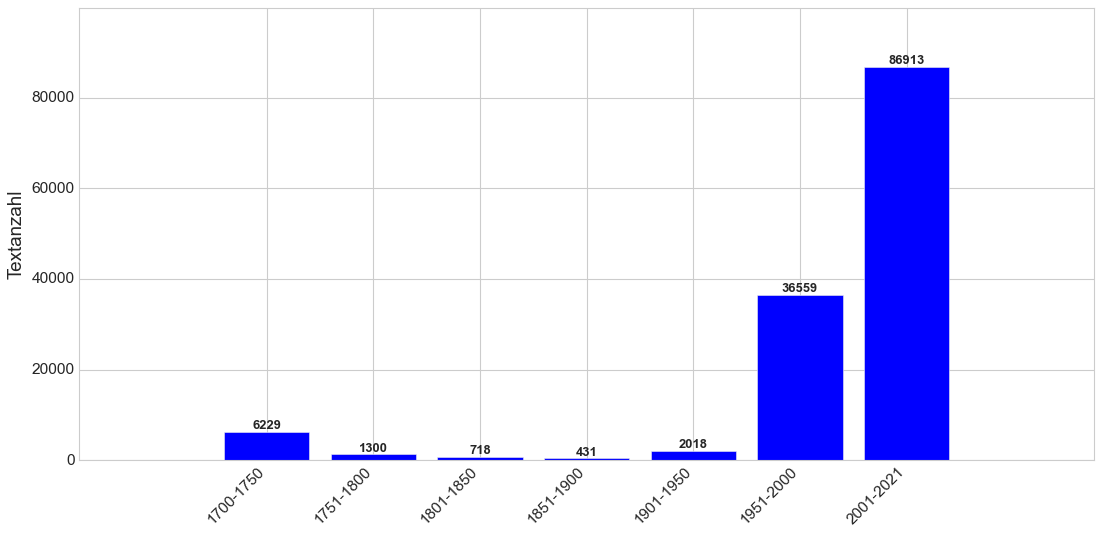

In [9]:
plt.figure(figsize=[14,7])
plt.style.use('seaborn-whitegrid')

x_indexes = np.arange(len(periods_norm))
plt.bar(x_indexes, per_len_norm.values(), label='Textanzahl', width=0.8, color='b')
plt.xticks(ticks = x_indexes, labels = per_len_norm.keys(), rotation=45, horizontalalignment='right')
#plt.xlabel('Zeiträume')
plt.ylabel('Textanzahl')

#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.margins(0.2, 0.15)

for i, j in zip(x_indexes, per_len_norm.values()):
       plt.annotate(j, xy=(i,j), xycoords='data', verticalalignment='bottom', horizontalalignment='center', 
                    fontweight='demi', fontsize='small')

#plt.savefig('Plots/corpusnorm_textanzahl.png')
plt.show()

### Anzahl der Tokens pro Zeitraum

In [10]:
sum_words_norm = {i: math.trunc(sum(df_norm[df_norm['period']==i].words)) for i in periods_norm}
sum_words_norm

{'1700-1750': 2168484,
 '1751-1800': 2146440,
 '1801-1850': 2151484,
 '1851-1900': 2149464,
 '1901-1950': 2152097,
 '1951-2000': 2154962,
 '2001-2021': 2140459}

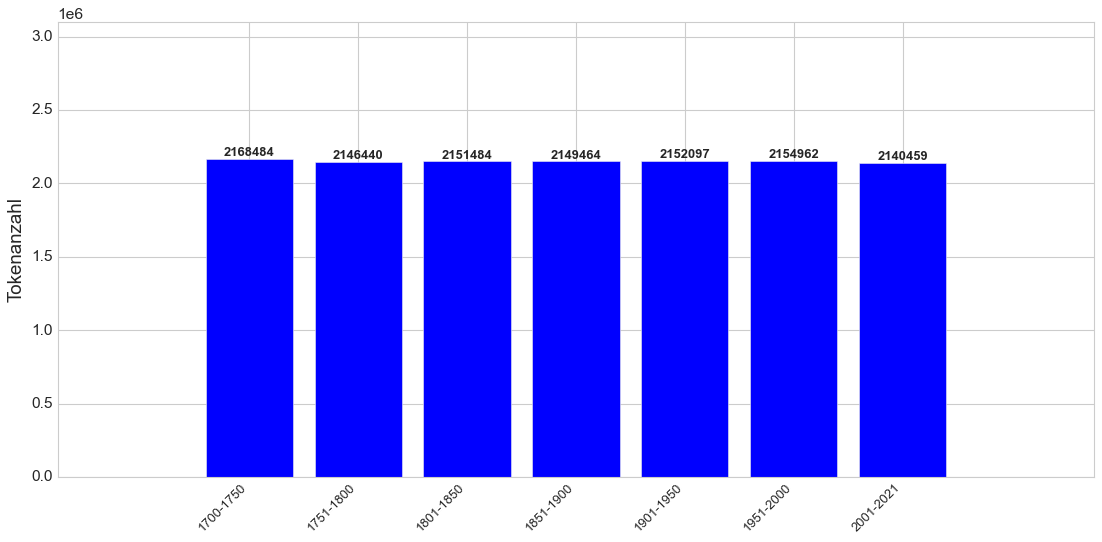

In [11]:
plt.figure(figsize=[14,7])
plt.style.use('seaborn-whitegrid')

x_indexes = np.arange(len(sum_words_norm))
plt.bar(x_indexes, sum_words_norm.values(), label='Tokenanzahl', width=0.8, color='b')
plt.xticks(ticks = x_indexes, labels = sum_words_norm.keys(), rotation=45, horizontalalignment='right', fontsize='small')
#plt.xlabel('Zeiträume')
plt.ylabel('Tokenanzahl')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 3100000)

plt.tight_layout()
plt.margins(0.2, 0.15)

for i, j in zip(x_indexes, sum_words_norm.values()):
       plt.annotate(j, xy=(i,j), xycoords='data', verticalalignment='bottom', horizontalalignment='center', 
                    fontweight='demi', fontsize='small')
        
#plt.savefig('Plots/corpusnorm_tokenanzahl.png')
plt.show()

### Verteilung der Texttypen auf die Zeiträume

In [12]:
period_frames = []

In [13]:
# Teilframes pro Zeitraum erstellen

df_periods = dict(tuple(df_norm.groupby(by='period')))

for df, period in zip(df_periods, periods_norm):
    df_period = df_periods[period]
    period_frames.append(df_period)

In [14]:
periods_texttypes = {}

In [15]:
# Anzahl der Texte pro Texttyp pro Zeitraum

for df, period in zip(period_frames, periods_norm):
    texttypes = df.groupby(by='text_type')
    types = texttypes.groups
    
    periods_texttypes[period] = {key : len(value) for key, value in types.items()}

In [16]:
periods_texttypes

{'1700-1750': {'espositivo': 14,
  'personale': 19,
  'poesia': 13,
  'prosa letteraria': 6158,
  'teatro': 25},
 '1751-1800': {'espositivo': 24,
  'personale': 9,
  'poesia': 17,
  'prosa letteraria': 1209,
  'teatro': 41},
 '1801-1850': {'espositivo': 19,
  'personale': 12,
  'poesia': 16,
  'prosa letteraria': 668,
  'teatro': 3},
 '1851-1900': {'espositivo': 6,
  'personale': 3,
  'poesia': 4,
  'prosa letteraria': 413,
  'stampa': 4,
  'teatro': 1},
 '1901-1950': {'espositivo': 14,
  'personale': 5,
  'poesia': 1,
  'prosa letteraria': 1967,
  'stampa': 31},
 '1951-2000': {'dialogo': 7,
  'espositivo': 16,
  'prosa letteraria': 228,
  'stampa': 36308},
 '2001-2021': {'dialogo': 3,
  'prosa letteraria': 3,
  'stampa': 72534,
  'web': 14373}}

In [17]:
periods_texttypes_token = {}

In [18]:
# Anzahl der Tokens pro Texttyp pro Zeitraum

for df, period in zip(period_frames, periods_norm):
    words = {i: math.trunc(sum(df[df['text_type']==i].words)) for i in list(df['text_type'].unique())}
    periods_texttypes_token[period] = words

In [19]:
periods_texttypes_token

{'1700-1750': {'personale': 236165,
  'espositivo': 869205,
  'poesia': 512572,
  'prosa letteraria': 299165,
  'teatro': 251377},
 '1751-1800': {'espositivo': 1174972,
  'personale': 232838,
  'poesia': 176934,
  'teatro': 428605,
  'prosa letteraria': 133091},
 '1801-1850': {'poesia': 168484,
  'espositivo': 1143011,
  'prosa letteraria': 192466,
  'teatro': 29440,
  'personale': 618083},
 '1851-1900': {'personale': 3812,
  'prosa letteraria': 1733921,
  'poesia': 59825,
  'espositivo': 335075,
  'stampa': 8008,
  'teatro': 8823},
 '1901-1950': {'prosa letteraria': 1488739,
  'personale': 210929,
  'espositivo': 437224,
  'stampa': 9279,
  'poesia': 5926},
 '1951-2000': {'stampa': 1646856,
  'prosa letteraria': 441566,
  'espositivo': 51532,
  'dialogo': 15008},
 '2001-2021': {'stampa': 1625079,
  'prosa letteraria': 161313,
  'dialogo': 3780,
  'web': 350287}}

In [20]:
espositivo = []
dialogo = []
poesia = []
personale = []
prosa_lett = []
stampa = []
teatro = []
web = []

In [21]:
# Werte des Texttyps rausziehen und in Liste speichern 

for i in periods_texttypes_token:
    
    esp = periods_texttypes_token.get(i, {}).get('espositivo')
    espositivo.append(esp)
    
    di = periods_texttypes_token.get(i, {}).get('dialogo')
    dialogo.append(di)
    
    po = periods_texttypes_token.get(i, {}).get('poesia')
    poesia.append(po)
    
    per = periods_texttypes_token.get(i, {}).get('personale')
    personale.append(per)
    
    prolet = periods_texttypes_token.get(i, {}).get('prosa letteraria')
    prosa_lett.append(prolet)
    
    st = periods_texttypes_token.get(i, {}).get('stampa')
    stampa.append(st)
    
    tea = periods_texttypes_token.get(i, {}).get('teatro')
    teatro.append(tea)
    
    w = periods_texttypes_token.get(i, {}).get('web')
    web.append(w)

In [22]:
# None mit 0 ersetzen

espositivo = [0 if v is None else v for v in espositivo]
dialogo = [0 if v is None else v for v in dialogo]
poesia = [0 if v is None else v for v in poesia]
personale = [0 if v is None else v for v in personale]
prosa_lett = [0 if v is None else v for v in prosa_lett]
stampa = [0 if v is None else v for v in stampa]
teatro = [0 if v is None else v for v in teatro]
web = [0 if v is None else v for v in web]

In [23]:
print(espositivo)
print(dialogo)
print(personale)
print(poesia)
print(prosa_lett)
print(stampa)
print(teatro)
print(web)

[869205, 1174972, 1143011, 335075, 437224, 51532, 0]
[0, 0, 0, 0, 0, 15008, 3780]
[236165, 232838, 618083, 3812, 210929, 0, 0]
[512572, 176934, 168484, 59825, 5926, 0, 0]
[299165, 133091, 192466, 1733921, 1488739, 441566, 161313]
[0, 0, 0, 8008, 9279, 1646856, 1625079]
[251377, 428605, 29440, 8823, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 350287]


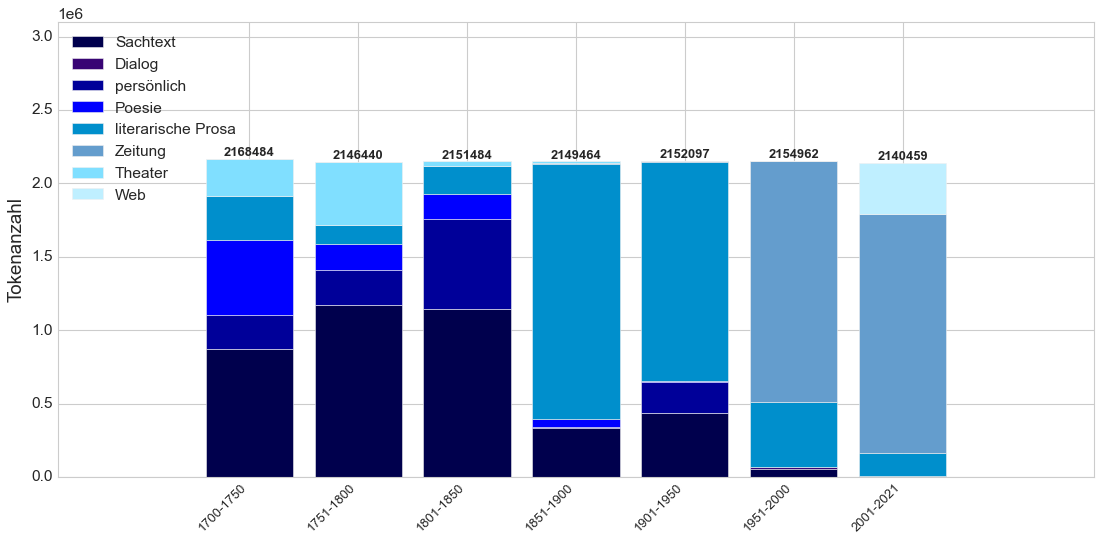

In [27]:
# Verteilung der Texttypen auf die Zeiträume

plt.figure(figsize=[14,7])
plt.style.use('seaborn-whitegrid')

data = np.array([espositivo, dialogo, personale, poesia, prosa_lett, stampa, teatro, web])
labels = ['Sachtext', 'Dialog', 'persönlich', 'Poesie', 'literarische Prosa', 
          'Zeitung', 'Theater', 'Web']
colors = ['#00004d','#380474', '#000099', '#0000FF', '#008fcc', '#649dcd', '#80dfff', '#BFEFFF']

X = np.arange(data.shape[1])
for i in range(data.shape[0]):
    plt.bar(X, data[i],bottom = np.sum(data[:i], axis=0),label=labels[i % len(labels)], color=colors[i % len(colors)])

x_indexes = np.arange(len(periods_norm))
plt.xticks(ticks=x_indexes, labels=periods_norm, rotation=45, horizontalalignment='right', fontsize='small')
#plt.xlabel('Zeiträume')
plt.ylabel('Tokenanzahl')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 3100000)
plt.legend(loc='upper left', fontsize='medium')

plt.tight_layout()
plt.margins(0.2, 0.2)

for i, j in zip(x_indexes, sum_words_norm.values()):
       plt.annotate(j, xy=(i,j), xycoords='data', verticalalignment='bottom', horizontalalignment='center', 
                    fontweight='demi', fontsize='small')

#plt.savefig('Plots/corpusnorm_tokenanzahl_texttypes.png')
plt.show()

In [95]:
# normalisiertes Korpus speichern

df_norm.to_csv('Korpus/corpus_norm.csv', encoding='utf-8', index=False)

In [2]:
# wieder einlesen 

df_norm = pd.read_csv('Korpus/corpus_norm.csv', sep=',', encoding='utf-8') 

### Kandidaten im normalisierten, lemmatisierten Korpus

In [98]:
# wieder einlesen 

df = pd.read_csv('Korpus/corpus_norm.csv', sep=',', encoding='utf-8') 

In [99]:
df.head()

,doc,source,author,title,year,period,text_type,words,text,cleaned_text,lemmatized_text
0,Personali.IV.4.Testo.txt,MIDIA,Vincenzo da Filicaia,Lettere inedite a Lorenzo Magalotti,1700.0,1700-1750,personale,10073.0,"IV. 4. Vincenzo da Filicaia, Lettere inedite a...","iv. . vincenzo da filicaia, lettere inedite a...","iv . 4 . Vincenzo da filicaia , lettere inedit..."
1,Personali.IV.15.Testo.txt,MIDIA,Pietro Giannone,Vita scritta da lui medesimo,1700.0,1700-1750,personale,10118.0,[Proemio]\nPrendo a scrivere la mia vita e qua...,proemio prendo a scrivere la mia vita e quan...,[ proemio ] \n prendere a scrivere il mio vita...
2,Espositivi.IV.4.Testo.txt,MIDIA,Ludovico Antonio Muratori,Antichità italiane,1700.0,1700-1750,espositivo,8990.0,"﻿IV. 4. Ludovico Antonio Muratori, Antichità i...","iv. . ludovico antonio muratori, antichità i...","﻿iv . 4 . Ludovico Antonio muratori , antichit..."
3,Personali.IV.5.Testo.txt,MIDIA,Lorenzo Magalotti,Lettere odorose (1693-1705),1700.0,1700-1750,personale,8374.0,"IV. 5. Lorenzo Magalotti, Lettere odorose (169...","iv. . lorenzo magalotti, lettere odorose ...","iv . 5 . Lorenzo magalotti , lettere odoroso (..."
4,Poesia.IV.1.Testo.txt,MIDIA,Giuseppe Paolucci (Alessi Cillenio),Poesie,1700.0,1700-1750,poesia,10862.0,IV. 1. Rime degli Arcadi: Alessi Cillenio (Giu...,iv. . rime degli arcadi: alessi cillenio giu...,iv . 1 . rima del arcadi : alessi cillenio ( G...


In [100]:
df.shape

(134168, 11)

In [101]:
df.text = df.text.fillna('')
df.lemmatized_text = df.lemmatized_text.fillna('')
df.cleaned_text = df.cleaned_text.fillna('')

In [102]:
# Teilframes pro Zeitraum erstellen

period_frames = []
periods = list(df['period'].unique())
df_periods = dict(tuple(df.groupby(by='period')))

for df, period in zip(df_periods, periods):
    df_period = df_periods[period]
    period_frames.append(df_period)

In [103]:
# Funktion, die bestimmte Wörter zählt

def count_keywords(df, keywords):
    keyword_dict = {w:w.replace(' ', '_') for w in keywords}

    corpus = ' '.join(df.lemmatized_text).lower()                     
    for w,w2 in keyword_dict.items():
        corpus = corpus.replace(w,w2)

    all_counts = Counter(corpus.split())
    final_counts = {w:all_counts[w2] for w,w2 in keyword_dict.items()}
    return final_counts

In [104]:
# mögliche Kandidaten

keywords = ['atrocemente', 'formidabilmente', 'mostruosamente', 'orrendamente', 
            'orribilmente', 'spaventosamente', 'terribilmente', 'tremendamente', 
            'molto', 'angoscia', 'angosciare', 'ansia', 'atterrire', 'panico', 
            'paura', 'raccapricciare', 'raccapriccio', 'schifo', 'sgomentare', 
            'sgomento', 'spaventare', 'spavento', 'terrore', 'domani', 'finora', 
            'ieri', 'oggi', 'presto', 'raramente', 'sempre', 'spesso']

In [105]:
candidates = {}

for df, period in zip(period_frames, periods):
    res = count_keywords(df, keywords)
    candidates[period] = res

In [106]:
candidates

{'1700-1750': {'atrocemente': 1,
  'formidabilmente': 0,
  'mostruosamente': 1,
  'orrendamente': 1,
  'orribilmente': 17,
  'spaventosamente': 5,
  'terribilmente': 7,
  'tremendamente': 0,
  'molto': 10543,
  'angoscia': 16,
  'angosciare': 0,
  'ansia': 1,
  'atterrire': 89,
  'panico': 8,
  'paura': 174,
  'raccapricciare': 4,
  'raccapriccio': 1,
  'schifo': 8,
  'sgomentare': 44,
  'sgomento': 6,
  'spaventare': 66,
  'spavento': 217,
  'terrore': 135,
  'domani': 32,
  'finora': 200,
  'ieri': 25,
  'oggi': 600,
  'presto': 274,
  'raramente': 9,
  'sempre': 1962,
  'spesso': 522},
 '1751-1800': {'atrocemente': 2,
  'formidabilmente': 0,
  'mostruosamente': 0,
  'orrendamente': 1,
  'orribilmente': 20,
  'spaventosamente': 1,
  'terribilmente': 8,
  'tremendamente': 0,
  'molto': 12933,
  'angoscia': 51,
  'angosciare': 0,
  'ansia': 2,
  'atterrire': 53,
  'panico': 5,
  'paura': 206,
  'raccapricciare': 1,
  'raccapriccio': 5,
  'schifo': 14,
  'sgomentare': 12,
  'sgomento': 

In [108]:
table = pd.DataFrame.from_dict(candidates, orient='index')
table

,atrocemente,formidabilmente,mostruosamente,orrendamente,orribilmente,spaventosamente,terribilmente,tremendamente,molto,angoscia,...,spavento,terrore,domani,finora,ieri,oggi,presto,raramente,sempre,spesso
1700-1750,1,0,1,1,17,5,7,0,10543,16,...,217,135,32,200,25,600,274,9,1962,522
1751-1800,2,0,0,1,20,1,8,0,12933,51,...,86,120,44,225,39,468,469,39,2403,689
1801-1850,8,0,2,9,49,3,31,2,9895,83,...,106,154,164,94,175,1002,365,20,2280,617
1851-1900,8,1,19,4,145,38,119,47,9461,131,...,113,186,493,96,222,677,569,33,2829,495
1901-1950,10,2,36,10,145,132,145,50,10679,191,...,115,218,573,138,354,972,524,43,2790,514
1951-2000,48,0,50,50,145,145,145,50,12374,338,...,162,361,639,533,1742,2138,614,290,3011,991
2001-2021,71,66,50,71,145,145,145,50,10375,126,...,106,173,619,246,1191,2087,349,100,2524,561


In [109]:
table.to_csv('Korpus/candidates_norm.csv', sep=';')